# Data Prep

Guia com os links antigos: https://docs.google.com/spreadsheets/d/16Uj_LQHQtvV5Rbowa0dRmKCetuVBQOmZ1mqB6OlaLz0/edit?usp=sharing

Usamos como ano inicial dos dados 1991 e ano final 2019

Dados de origem: /content/drive/MyDrive/TCC/data/entrada

Dados processados: /content/drive/MyDrive/TCC/data/csv

## Funções e constantes

In [870]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [871]:
# path dos dados no drive
PATH = "/content/drive/MyDrive/TCC/data/entrada/"

# constantes dos anos

# o modelo usa dados de 1991 a 2019, mas como usamos alguns indicadores 
#acumulados de 12 meses, precisamos pegar o ano anterior
ANO_ANT = 1990

ANO_INICIAL = 1991
ANO_FINAL = 2019

# anos a partir de 1990
ANOS = [f"{i}" for i in range(ANO_ANT, ANO_FINAL+1)]

# anos usados (1991 a 2019)
ANOS_BASE=[f"{i}" for i in range(ANO_INICIAL, ANO_FINAL+1)]

MESES = [f"{i:02d}" for i in range(1, 13)]

# datas usadas (de janeiro de 1991 ate dezembro de 2019)
# formato: yyyymmm => 199101 -> jan/1991
ANO_MES = [a+m for a in [f"{i}" for i in range(ANO_INICIAL, ANO_FINAL+1)] for m in MESES]

# datas mas que se iniciam de 1990 
# formato: yyyymmm => 199101 -> jan/1991
ANO_MES_BASE = [a+m for a in ANOS for m in MESES]

SIGLAS = ["AC","AL","AM","AP","BA","CE",
          "DF","ES","GO","MA","MG","MS",
          "MT","PA","PB","PE","PI","PR",
          "RJ","RN","RO","RR","RS","SC",
          "SE","SP","TO"]

ESTADOS = ['Acre', 'Alagoas', 'Amazonas', 'Amapá', 'Bahia', 'Ceará',
  'Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão',
  'Minas Gerais', 'Mato Grosso do Sul', 'Mato Grosso', 'Pará', 'Paraíba',
  'Pernambuco', 'Piauí', 'Paraná', 'Rio de Janeiro',
  'Rio Grande do Norte', 'Rondônia', 'Roraima', 'Rio Grande do Sul',
  'Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

ESTADOS = [i.title() for i in ESTADOS]

MAP = {}
for i in range(len(ESTADOS)):
  MAP[ESTADOS[i]] = SIGLAS[i]

In [872]:
# pega um dataframe com dados anuais e 
# devolve no formato ano_mes acumulado ou não
def get_data_anual (file, name, ac=True):

    df = pd.read_csv(file, usecols=["Sigla"] + [f"{ANO_ANT}"] + ANOS)

    df_mes = pd.DataFrame()
    df_mes["indicador"] = [name]*27
    df_mes["estado"] = SIGLAS

    # trandorma dado anual em mensal    
    for i in range(len(ANO_MES_BASE)):
        df_mes[f"{ANO_MES_BASE[i]}"] = df[f"{1990 + i//12}"].divide(12)

    df_ac = pd.DataFrame()
    df_ac["indicador"] = [name]*27
    df_ac["estado"] = SIGLAS

    for i in range(len(ANO_MES)):

        # se for passado AC = True, acumula os dados a cada 12 meses
        if ac:
            df_ac[f"{ANO_MES[i]}"] = df_mes[ANO_MES_BASE[1+i:12+i]].sum(axis=1)
        else:
            df_ac[f"{ANO_MES[i]}"] = df_mes[ANO_MES_BASE[1+i:12+i]].mean(axis=1)

    return df_ac

In [873]:
# pega dado mensal a nivel do brasil 
# e replica para os estados
def get_data_mensal_br (file, ind):

  df = pd.read_csv(file,index_col=0).T

  df_ind=pd.DataFrame()
  df_ind["indicador"]=[ind]*27
  df_ind["estado"]=SIGLAS

  for i in range(len(ANO_MES)):
    df_ind[ANO_MES[i]] =  df.iloc[i%12, i//12]

  return df_ind


## PIBs do estado
- `pib_pc  `: PIB do estado a preços constantes
- `pib_pmc `: PIB do estado a preços de mercado
- `pib_pcpt`: PIB per capita do estado

Obs:

- Fonte: IBGE
- Link: ipeadata
- Granularidade: anual por estado
- sem dados faltantes

Processo: 
- supomos que o pib anual pode ser igualmente dividido entre os meses
- Dividir medição anual para obter os valores mensais
- acumular o valor mensal calculado para obter o dado anualizado em cada mês


In [874]:
df = pd.DataFrame(columns=["indicador", "estado"] + ANO_MES)
df = df.append(get_data_anual(PATH+"pib_precos_constantes.csv", "pib_pc"))
df = df.append(get_data_anual(PATH+"pib_precos_mercado_corrente.csv", "pib_pmc"))
df = df.append(get_data_anual(PATH+"pib_per_capita.csv", "pib_pcpt", False))

## População

- `populacao`: População do estado

- Fonte: IBGE
- Link: https://basedosdados.org/dataset/br-ibge-populacao
- Granularidade: anual por estado
- sem dados faltantes

Processo: 
- supomos que a população em cada mês de um ano no estado é a mesma da medição anual


In [875]:
pop = pd.read_csv(PATH+'populacao.csv')

df_pop = pd.DataFrame(SIGLAS,columns=["Sigla"])

for i in range(len(ANOS_BASE)):
  df_pop[ANOS_BASE[i]]=pop.iloc[i:27+i,2].to_list()

# dataframe com os dados de populacao
df_pop_mensal=pd.DataFrame()
df_pop_mensal["indicador"]=["populacao"]*27
df_pop_mensal["estado"]=SIGLAS

for i in range(len(ANO_MES)):

  df_pop_mensal[ANO_MES[i]] = df_pop[ANOS_BASE[i//12]]

df = df.append(df_pop_mensal)

## PIB da construção civil

- `pib_cc`: PIB  da construção civil do estado

Obs:

- Fonte: IBGE
- Link: ipeadata
- Granularidade: anual por estado
- sem dados faltantes

Processo: 
- supomos que o pib da construção civil anual pode ser igualmente dividido entre os meses
- Dividir medição anual para obter os valores mensais
- acumular o valor mensal calculado para obter o dado anualizado em cada mês


In [876]:
df = df.append(get_data_anual(PATH+"pib_construcao_civil.csv", "pib_cc"))

## INCC e IPCA

- `incc`: Índice Nacional da Construção Civil
-`ipca`: Índice de Preços ao Consumidor Amplo

- Fonte do IPCA: IBGE
- Fonte do INCC: FGV


Granularidade: mensal para o Brasil

Processo: 
- supor que o valor da medição dos indicadores de cada um dos estados de um mês específico é igual à medição do Brasil todo.

In [877]:
df = df.append(get_data_mensal_br(PATH+"ipca.csv", "ipca"))
df = df.append(get_data_mensal_br(PATH+"INCC.csv", "incc"))

## IGP

- `igp`: Índice Geral de Preços

Fonte: FGV

Granularidade: mensal para o Brasil

Processo: 
- supor que o valor da medição dos indicadores de cada um dos estados de um mês específico é igual à medição do Brasil todo.

In [878]:
igp = pd.read_csv(PATH+"igp.csv")

igp = igp.dropna(axis="columns", how="any")
igp.columns = ["ano_mes", "indice"]
igp["ano_mes"].astype(str)
igp = igp.T

igp.columns = [f"{int(i)}" for i in list(igp.iloc[0])]
igp = igp.iloc[1:]

df_igp=pd.DataFrame()
df_igp["indicador"]=["igp"]*27
df_igp["estado"]=SIGLAS

for i in ANO_MES:

  df_igp[i] = igp[i].iloc[0]

df = df.append(df_igp)

## SELIC

- `selic`: taxa básica de juros

Fonte: API do BACEN

Granularidade: mensal para o Brasil

Processo: 
- supor que o valor da medição dos indicadores de cada um dos estados de um mês específico é igual à medição do Brasil todo.

In [879]:
df_selic = pd.read_csv(PATH + "SELIC.csv").T

df_selic.columns= df_selic.iloc[0].astype(int).astype(str)
df_selic = df_selic.iloc[1:]
df_selic=df_selic[ANOS]

df_mensal = pd.DataFrame()
df_mensal["indicador"]=["selic"]*27
df_mensal["estado"]=SIGLAS

for i in range(len(ANO_MES)):
  df_mensal[ANO_MES[i]] =  df_selic.iloc[i%12, i//12]

df = df.append(df_mensal)

## IDH

- `idh_l`: Índice de Desenvolvimento Humano (Longevidade)
- `idh_r`: Índice de Desenvolvimento Humano (Renda)
- `idh_e`: Índice de Desenvolvimento Humano (Educação)

Granularidade:
- os dados estavam disponíveis nos anos de 1991,2000 e 2010 por conta do CENSO
- entre 2012 e 2017 também temos os indicadores por conta da PNAD contínua

Fonte: IBGE

Processo:
- interpolação para obter os dados anuais faltantes 
- consideramos medições dos meses pertencentes a um ano iguais a medição anual


In [880]:
idh_l = pd.read_csv(PATH+"idh_longevidade.csv")

idh_l[list(set(ANOS[1:]) - set(idh_l.columns[1:]))] = np.nan
idh_l = idh_l.reindex(sorted(idh_l.columns), axis=1)

estados = idh_l["Territorialidades"]
idh_l = idh_l.drop("Territorialidades", axis=1).interpolate(method="linear", axis=1, limit_direction="both")

idh_l_full = pd.DataFrame()
idh_l_full["indicador"]=["idh_long"]*27
idh_l_full["estado"]=SIGLAS

for i in range(len(ANO_MES)):

  idh_l_full[ANO_MES[i]] = idh_l[ANOS_BASE[i//12]]

df = df.append(idh_l_full)

In [881]:
idh_r = pd.read_csv(PATH+"idh_renda.csv")
idh_r[list(set(ANOS[1:]) - set(idh_r.columns[1:]))] = np.nan
idh_r = idh_r.reindex(sorted(idh_r.columns), axis=1)

estados = idh_r["Territorialidades"]
idh_r = idh_r.drop("Territorialidades", axis=1).interpolate(method="linear", axis=1, limit_direction="both")

idh_r_full = pd.DataFrame()
idh_r_full["indicador"]=["idh_renda"]*27
idh_r_full["estado"]=SIGLAS

for i in range(len(ANO_MES)):

  idh_r_full[ANO_MES[i]] = idh_r[ANOS_BASE[i//12]]

df = df.append(idh_r_full)

In [882]:
idh_e = pd.read_csv(PATH+"idh_educacao.csv")

idh_e[list(set(ANOS[1:]) - set(idh_e.columns[1:]))] = np.nan
idh_e = idh_e.reindex(sorted(idh_e.columns), axis=1)

estados = idh_e["Territorialidades"]

idh_e = idh_e.drop("Territorialidades", axis=1).interpolate(method="linear", axis=1, limit_direction="both")

idh_e_full = pd.DataFrame()
idh_e_full["indicador"]=["idh_educacao"]*27
idh_e_full["estado"]=SIGLAS

for i in range(len(ANO_MES)):

  idh_e_full[ANO_MES[i]] = idh_e[ANOS_BASE[i//12]]

df = df.append(idh_e_full)

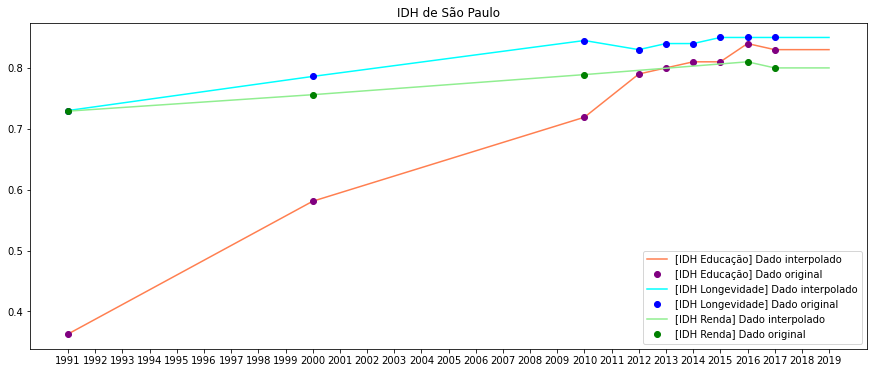

In [883]:
# celula para comparar os resultados interpolados

def dif_orig_interp (file):
  orig = pd.read_csv(file).T
  orig.columns = orig.iloc[0]  
  orig = orig.iloc[1:]    

  interp = pd.read_csv(file)
  interp[list(set(ANOS[1:]) - set(interp.columns[1:]))] = np.nan
  interp = interp.reindex(sorted(interp.columns), axis=1)

  estados = interp["Territorialidades"]

  interp = interp.drop("Territorialidades", axis=1).interpolate(method="linear", axis=1, limit_direction="both").T
  interp.columns = estados

  return orig, interp

idh_e_orig, idh_e_interp = dif_orig_interp(PATH + "idh_educacao.csv")
idh_r_orig, idh_r_interp = dif_orig_interp(PATH + "idh_renda.csv")
idh_l_orig, idh_l_interp = dif_orig_interp(PATH + "idh_longevidade.csv")

plt.figure(figsize=(15,6))

plt.title("IDH de São Paulo")

plt.plot(idh_e_interp["São Paulo"], color='coral', label="[IDH Educação] Dado interpolado")
plt.plot(idh_e_orig["São Paulo"], color="purple", marker="o", label="[IDH Educação] Dado original", linestyle=" ")

plt.plot(idh_l_interp["São Paulo"], color='aqua', label="[IDH Longevidade] Dado interpolado")
plt.plot(idh_l_orig["São Paulo"], color="b", marker="o", label="[IDH Longevidade] Dado original", linestyle=" ")

plt.plot(idh_r_interp["São Paulo"], color='lightgreen', label="[IDH Renda] Dado interpolado")
plt.plot(idh_r_orig["São Paulo"], color="g", marker="o", label="[IDH Renda] Dado original", linestyle=" ")

plt.legend()

plt.show()

## NFSP

- `nfsp`: Necessidade de Financiamento do Setor Público

- Fonte: BACEN

- Granularidade: mensal para o Brasil

Processo:
- consideramos a medição mensal para o Brasil como medida individual de cada estado

In [884]:
nfsp = pd.read_csv(PATH+"nfsp.csv", names=["data", "nfsp"], skiprows=1)
nfsp = nfsp.iloc[12:]

df_nfsp = pd.DataFrame()
df_nfsp["indicador"]=["nfsp"]*27
df_nfsp["estado"]=SIGLAS

for i in range(len(ANO_MES)):

  df_nfsp[ANO_MES[i]] = nfsp.iloc[i, 1]

df = df.append(df_nfsp)

## Estoque

- `estoque`: Estoque Líquido de Capital Fixo - contrução

Fonte: IPEA

Granularidade: mensal para o Brasil

Processo:
- consideramos a medição mensal para o Brasil como medida individual de cada estado

In [885]:
estoque = pd.read_csv(PATH+"estoque.csv", names=["data", "estoque", "xx"], skiprows=1)
estoque = estoque.dropna(axis=1)
estoque = estoque.iloc[44:]

df_estoque = pd.DataFrame()
df_estoque["indicador"]=["estoque"]*27
df_estoque["estado"]=SIGLAS

for i in range(len(ANO_MES)):

  df_estoque[ANO_MES[i]] = estoque.iloc[i//12, 1]

df = df.append(df_estoque)

## Desemprego

- `desemprego`: Taxa de Desemprego

Fonte:
- IPEA (1992 até 2014)
- IBGE (2012 até 2019)

Granularidade:
- os dados do IPEA são medidos anualmente para cada estado do Brasil
- já os dados do IBGE são medidos mensalmente

Processo:
- utilizamos interpolação para lidar com os dados anuais faltantes

In [886]:
df_desemp = pd.DataFrame()
df_desemp["indicador"]=["desemprego"]*27
df_desemp["estado"]=SIGLAS

In [887]:
desemp_bf = pd.read_csv(PATH+"desemprego_b2015.csv", sep=";", skiprows=1, decimal=",")

desemp_bf = desemp_bf.dropna(axis=1).drop(["Sigla", "Código","Estado"], axis=1)
desemp_bf[list(set(ANOS)- set(desemp_bf.columns))] = np.nan
desemp_bf = desemp_bf.reindex(sorted(desemp_bf.columns), axis=1)

desemp_bf=desemp_bf.interpolate(method="linear", axis=1, limit_direction="both")

for i in range(255):
  df_desemp[ANO_MES[i]] = desemp_bf.iloc[:,i//12]

In [888]:
desemp_af = pd.read_csv(PATH+"desemprego_a2015.csv", sep=";", skiprows=1, decimal=",")

for i in range(254, len(ANO_MES)):
  df_desemp[ANO_MES[i]] = desemp_af.iloc[0,i-254]

In [889]:
df = df.append(df_desemp)

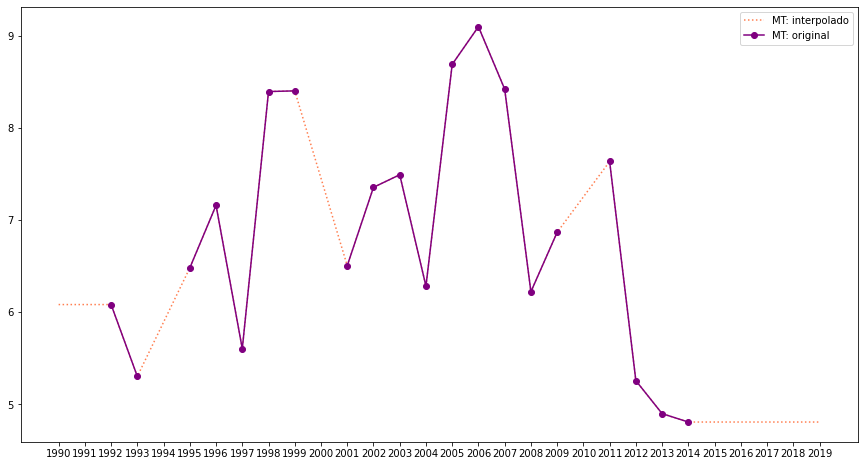

In [915]:
orig = pd.read_csv(PATH+"desemprego_b2015.csv", sep=";", skiprows=1, decimal=",")

orig = orig.dropna(axis=1).drop(["Sigla", "Código","Estado"], axis=1)
orig[list(set(ANOS)- set(orig.columns))] = np.nan
orig = orig.reindex(sorted(orig.columns), axis=1)

interp=orig.interpolate(method="linear", axis=1, limit_direction="both")

plt.figure(figsize=(15,8))

plt.plot(interp.iloc[12].T, linestyle=":", label=f"{SIGLAS[12]}: interpolado", color="coral")
plt.plot(orig.iloc[12].T, marker="o", label=f"{SIGLAS[12]}: original", color="purple")

plt.legend()

plt.show()

#Salvando em um arquivo csv

In [890]:
data = ANO_MES*len(SIGLAS)
data.sort()
df_base = pd.DataFrame({"estados": SIGLAS*len(ANO_MES),
                        "data": data}, columns=["estados", "data"])


In [891]:
for col in df["indicador"].unique():

  ind = []

  for i in ANO_MES:

    ind += df[df["indicador"] == col][i].to_list()

  df_base[col] = ind

In [751]:
df_base.to_csv("/content/drive/MyDrive/TCC/data/csv/input.csv", index=False)

# Consumo

Variável resposta

Dados mensais disponíveis de 1991 até 2000 e de 2003 a 2019

Métodos para lidar com os dados faltantes:
- média anual

- interpolação


In [752]:
def get_consumo_mes (df):
  df_consumo = pd.DataFrame()

  for state in ESTADOS:
    df_consumo[MAP[state]] = df[df["estados"] == state].iloc[0,1:-1].values

  return df_consumo

In [894]:
df_consumo = pd.DataFrame()

In [895]:
consumo = pd.read_excel(PATH+"consumo_mensal_90_2000.xlsx", sheet_name="90")
consumo = consumo.dropna()

# dropando columas com "Total"
cols = list(consumo.iloc[0].str.contains("Total"))
index = [i for i in range(len(cols)) if cols[i] == True]
consumo.drop(columns=consumo.columns[index], inplace=True)

# dropando coluna duplicada
consumo = consumo.iloc[1:]

# acertando nome  das colunas
consumo.columns=["estados"]+ANO_MES_BASE[:12]

consumo["estados"]=consumo["estados"].str.title()

df_consumo_ant = pd.DataFrame(ANO_MES_BASE[:12], columns=["data"])

for state in ESTADOS:
  df_consumo_ant[MAP[state]] = consumo[consumo["estados"] == state].iloc[0, 1:].values

df_consumo = df_consumo.append(df_consumo_ant)

In [896]:
consumo = pd.read_excel(PATH+"consumo_mensal_90_2000.xlsx", sheet_name="91-00")
consumo = consumo.dropna()

# dropando columas com "Total"
cols = list(consumo.iloc[0].str.contains("Total"))
index = [i for i in range(len(cols)) if cols[i] == True]
consumo.drop(columns=consumo.columns[index], inplace=True)

# dropando coluna duplicada
consumo = consumo.iloc[1:]

# acertando nome  das colunas
consumo.columns=["estados"]+ANO_MES[:120]

consumo["estados"]=consumo["estados"].str.title()

df_consumo_bf = pd.DataFrame(ANO_MES[:120], columns=["data"])

for state in ESTADOS:
  df_consumo_bf[MAP[state]] = consumo[consumo["estados"] == state].iloc[0, 1:].values

df_consumo = df_consumo.append(df_consumo_bf)

In [897]:
consumo = pd.read_excel(PATH+"consumo_anual.xlsx", skiprows=2, names=["estados"]+ANOS[:22], header=None)
consumo = consumo.iloc[1:-6]
consumo=consumo[["estados","2001","2002"]].dropna()

consumo["estados"]=consumo["estados"].str.title()

df_consumo_anual = pd.DataFrame(ANO_MES[120:144], columns=["data"])

for state in ESTADOS:

    lis = []
    for i in consumo[consumo["estados"] == state].iloc[0, 1:].to_list():
        lis += 12 * [1000*i]
    df_consumo_anual[MAP[state]] = lis

df_consumo = df_consumo.append(df_consumo_anual)

In [898]:
consumo = pd.read_excel(f"{PATH}consumo_mensal_2003.xlsx", skiprows=4, sheet_name=None)

anomes = 144

for ano in ANOS[13:]:

  df_anual = consumo[ano].dropna().drop("TOTAL", axis=1).iloc[:-1]
  df_anual["estados"] = df_anual.iloc[:,0].str.lstrip().str.title()
  df_anual = get_consumo_mes(df_anual)
  df_anual["data"] = ANO_MES[anomes:anomes+12]
  anomes += 12
  df_consumo = df_consumo.append(df_anual)


In [758]:
df_consumo.to_csv('/content/drive/MyDrive/TCC/data/csv/target_abs.csv', index=False)

In [863]:
aux_ac = pd.DataFrame(columns=SIGLAS)

for i in range(len(ANO_MES)):
    aux_ac=aux_ac.append(pd.DataFrame(df_consumo.iloc[1+i:13+i, 1:].sum()).T)

df_consumo_ac = pd.DataFrame(columns=["data","estados","consumo"])

df_consumo_ac["data"] = ANO_MES*len(SIGLAS)
df_consumo_ac["estados"] = SIGLAS*len(ANO_MES)

states = []

for i in aux_ac.to_numpy().tolist():
    states += i

df_consumo_ac["consumo"] = states

df_consumo_ac.to_csv('/content/drive/MyDrive/TCC/data/csv/target_ac.csv', index=False)